<a href="https://colab.research.google.com/github/Akasxh/Deepfake_Detection/blob/main/deepfake_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
birdy654_cifake_real_and_ai_generated_synthetic_images_path = kagglehub.dataset_download('birdy654/cifake-real-and-ai-generated-synthetic-images')

print('Data source import complete.')


In [ ]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
def print_in_color(txt_msg,fore_tupple= (0,255,255) ,back_tupple=(0,0,0)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat))
    print('\33[0m', end='') # returns default print color to back to black

In [ ]:
fpath=r'/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL/0000 (10).jpg'
img=cv2.imread(fpath)
print('Image shape is ', img.shape)

Image shape is  (32, 32, 3)


In [ ]:
limiter = 20000
test_dir=r'/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'
train_dir=r'/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
classes=sorted(os.listdir(train_dir))
print('there are ', len(classes), ' classes ', classes[0], ' and ', classes[1])
dir_list=[train_dir, test_dir]
names=['train', 'test']
zip_list=zip(names, dir_list)
for name, dir in zip_list:
    filepaths=[]
    labels=[]
    class_list=sorted(os.listdir(dir))
    for klass in class_list:
        classpath=os.path.join(dir, klass)
        flist=sorted(os.listdir(classpath))
        if name == 'train':
            flist=np.random.choice(flist, limiter, replace=False) # randomly select limiter number of files from train_dir for each class
        desc=f'{name}-{klass}'
        for f in tqdm(flist, ncols=100, colour='blue', unit='files', desc=desc):
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if name == 'train':
        train_df=pd.concat([Fseries, Lseries], axis=1)
        train_df, valid_df=train_test_split(train_df, test_size=.1, shuffle=True, random_state=123, stratify=train_df['labels'])
    else:
        test_df=pd.concat([Fseries, Lseries], axis=1)
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

there are  2  classes  FAKE  and  REAL


test-REAL: 100%|███████████████████████████████████████| 10000/10000 [00:00<00:00, 449617.73files/s]

train_df length:  36000   test_df length:  20000   valid_df length:  4000


In [ ]:
gen=ImageDataGenerator()
# I will be using an EfficientNet model which requires a minimum image size of 32 X 32
img_size=(32,32)
bs=200 # set the batch size
train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'categorical', color_mode='rgb', shuffle=True, batch_size=bs)
valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'categorical', color_mode='rgb', shuffle=False, batch_size=bs)
test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'categorical', color_mode='rgb', shuffle=False, batch_size=bs)
labels=test_gen.labels

Found 36000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
img_shape=(img_size[0], img_size[1], 3)
base_model=tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(2, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', F1_score])

In [ ]:
# Initial training for `ask_epoch` epochs
history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,  # Setting verbose to 1 for progress display
    validation_data=valid_gen,
    shuffle=True
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.5033 - f1_score: 0.5033 - loss: 58.4202 - val_accuracy: 0.4955 - val_f1_score: 0.4955 - val_loss: 5.7009
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 112s 612ms/step - accuracy: 0.4907 - f1_score: 0.4907 - loss: 5.5441 - val_accuracy: 0.4975 - val_f1_score: 0.4975 - val_loss: 5.0941
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 112s 616ms/step - accuracy: 0.4974 - f1_score: 0.4974 - loss: 4.9442 - val_accuracy: 0.4972 - val_f1_score: 0.4972 - val_loss: 4.4866
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 112s 612ms/step - accuracy: 0.4986 - f1_score: 0.4986 - loss: 4.3332 - val_accuracy: 0.4965 - val_f1_score: 0.4965 - val_loss: 3.8739
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 112s 614ms/step - accuracy: 0.4966 - f1_score: 0.4966 - loss: 3.7214 - val_accuracy: 0.4988 - val_f1_score: 0.4987 - val_loss: 3.2732
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 113s 617ms/step - accuracy: 0.4999 - f1_score: 0.4999 - loss: 3.1284 - val_accuracy: 0.4902 - val_f1_sc

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Generate predictions on the validation set
y_pred = model.predict(valid_gen)

# Convert predictions to class labels (assuming binary classification)
y_pred_classes = y_pred.argmax(axis=1)  # For multi-class, choose the index of the max probability
y_true = valid_gen.classes  # Assuming valid_gen is a generator and provides true labels

# Calculate and print F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')  # 'weighted' accounts for label imbalance; you can use 'macro' or 'micro' if preferred
print(f"F1 Score: {f1}")

# Optional: Print a detailed classification report
print(classification_report(y_true, y_pred_classes))


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step
F1 Score: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2000
           1       0.50      1.00      0.67      2000

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.33      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step


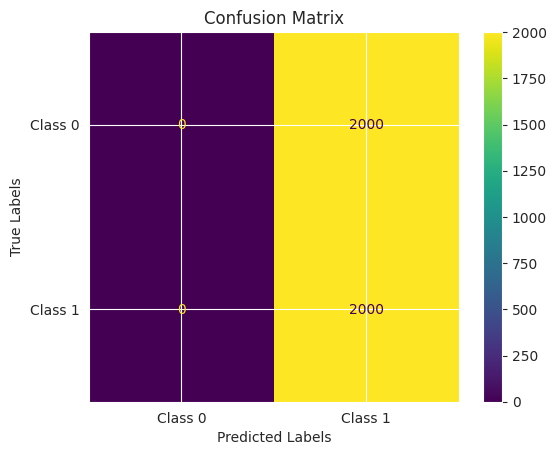

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions on the validation set
y_pred = model.predict(valid_gen)
y_pred_classes = y_pred.argmax(axis=1)  # Assuming multi-class; for binary use a threshold (e.g., y_pred > 0.5)

# Get true labels
y_true = valid_gen.classes  # Assuming `valid_gen` is a generator with true labels

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix as a chart
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='viridis')  # 'viridis' is a colormap; you can change it as desired
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Labels')
disp.ax_.set_ylabel('True Labels')

import matplotlib.pyplot as plt
plt.show()


In [ ]:
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    test_count =len(preds)
    misclassified_classes=[]
    misclassified_files=[]
    misclassified_as = []
    pred_indices=[]
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]
        if  pred_index != true_index:
            errors +=1
            misclassified_classes.append(classes[true_index])
            misclassified_as.append(classes[pred_index])
            file=test_gen.filenames[i]
            split=file.split('/')
            L=len(split)
            f=split[L-2] +' '+ split[L-1]
            misclassified_files.append(f)

    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels)
    ypred=np.array(pred_indices)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg)
    misclassified_classes=sorted(misclassified_classes)
    if len(misclassified_classes) > 0:
        misclassifications=[]
        for klass in misclassified_classes:
            mis_count=misclassified_classes.count(klass)
            misclassifications.append(mis_count)
        unique=len(np.unique(misclassified_classes))
        if unique==1:
            height=int(unique)
        else:
            height =int(unique/2)
        plt.figure(figsize=(10, height))
        plt.style.use('fivethirtyeight')
        plt.barh(misclassified_classes, misclassifications )
        plt.title( 'Classification Errors on Test Set by Class', fontsize=20, color='blue')
        plt.xlabel('NUMBER OF MISCLASSIFICATIONS', fontsize=20, color='blue')
        plt.ylabel('CLASS', fontsize=20, color='blue')
        plt.show()
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
        print("Classification Report:\n----------------------\n", clr)
    return f1score

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step
There were 9997 errors in 20000 tests for an accuracy of  50.02 and an F1 score of  33.37


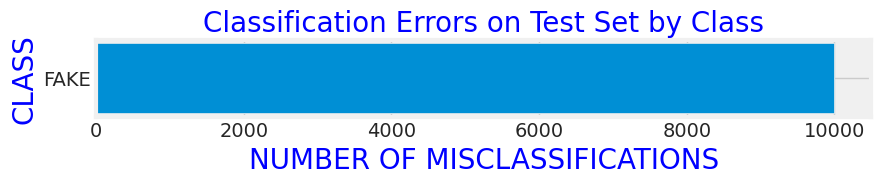

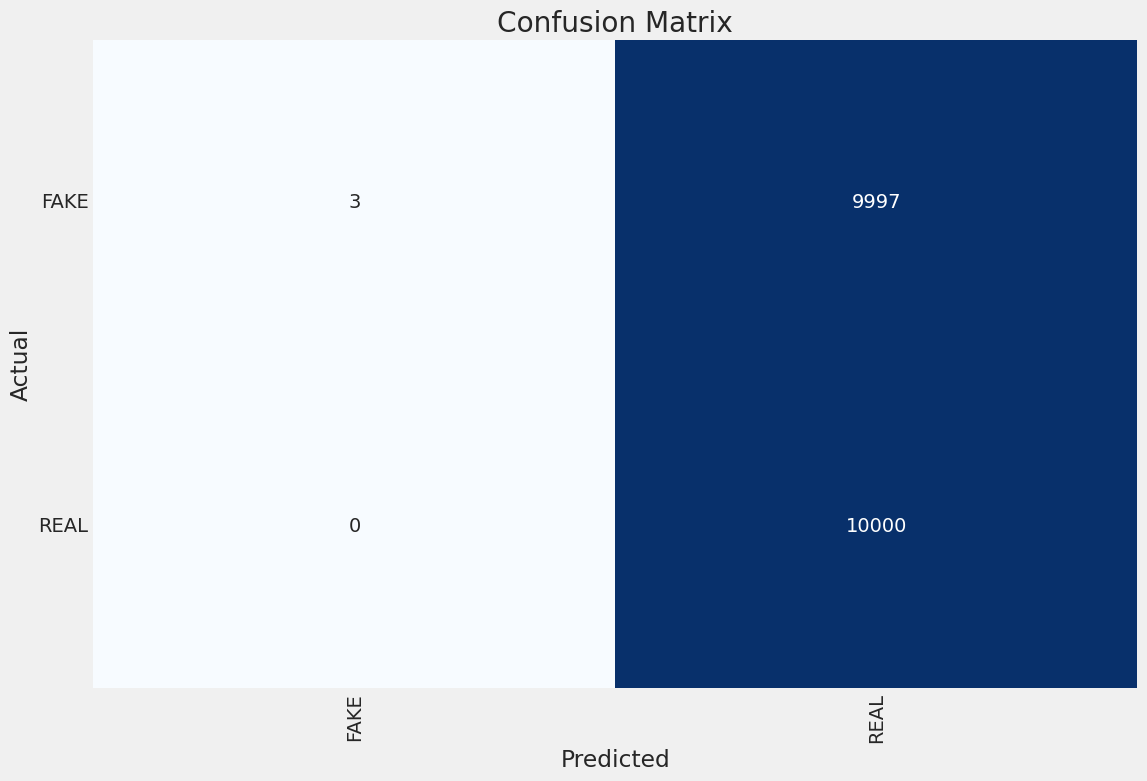

Classification Report:
----------------------
               precision    recall  f1-score   support

        FAKE     1.0000    0.0003    0.0006     10000
        REAL     0.5001    1.0000    0.6667     10000

    accuracy                         0.5001     20000
   macro avg     0.7500    0.5001    0.3337     20000
weighted avg     0.7500    0.5001    0.3337     20000



In [ ]:
f1score=predictor(model,test_gen)

In [ ]:
output_path = '/kaggle/working/my_model.h5'
model.save(output_path)


NameError: name 'model' is not defined